In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from math import comb

plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

In [2]:
# Noisy training data
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

In [3]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

In [4]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

/Users/pozzolabadmin/opt/anaconda3/envs/DOE/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


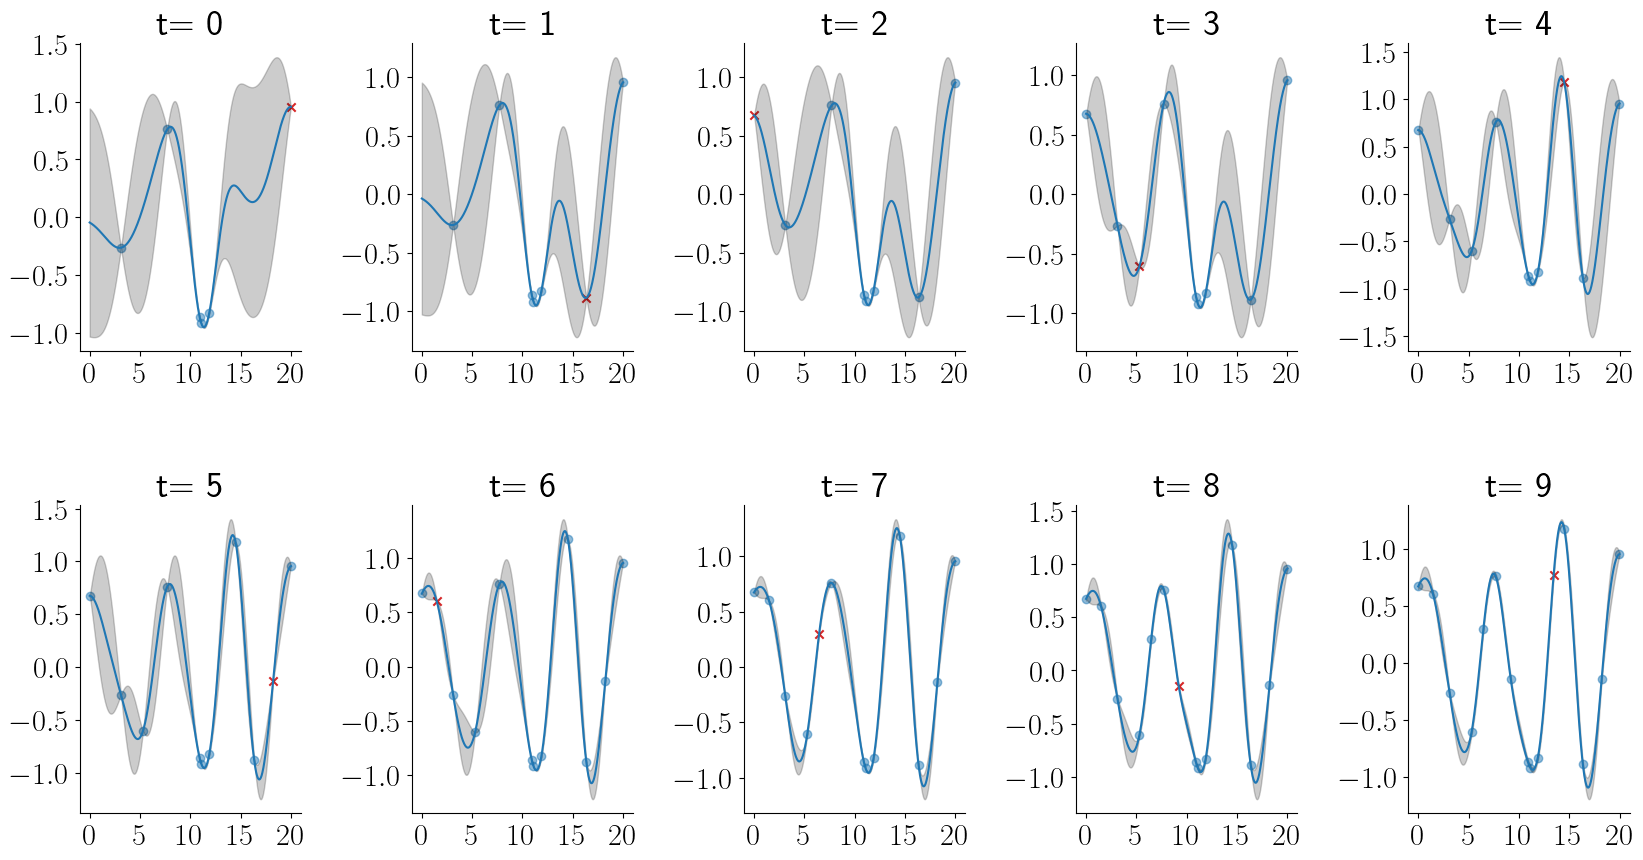

In [5]:
# active learning
def plot(gp, ax):
    x = np.linspace(0, 20, 1000)
    pred, std = gp.predict(x.reshape(-1,1), return_std=True)
    ax.plot(x, pred)
    ax.fill_between(x, 
                    pred.reshape(-1, )-std, 
                    pred.reshape(-1, )+std, 
                    alpha=0.2,
                    color='k',
                   )
    
    return

n_queries = 10

with plt.style.context(plt_style):
    fig, axs = plt.subplots(2,5, figsize=(4*5, 5*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    axs = axs.flatten()
    for idx in range(n_queries):
        axs[idx].scatter(regressor.X_training, regressor.y_training, 
                         color='tab:blue',
                         alpha=0.5
                        )
        query_idx, query_instance = regressor.query(X)
        regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
        axs[idx].scatter(X[query_idx], y[query_idx], marker='x', color='tab:red')
        plot(regressor, axs[idx])
        axs[idx].set_title('t= %d' % idx)
        
    plt.savefig('./Figures/lec18_1.pdf')